<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Timeseries_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adolescent and Young Adult Group Whole Brain Cross Validation
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

## Adolescent Time Series Cross Validation
### Organize Data Adolescent for Cross Validation
If we are performing cross validation, we need to get the data without custom splitting

In [6]:
from google.colab import drive, files
drive.mount('/content/gdrive', force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Mounted at /content/gdrive
Cloning into 'teambrainiac'...
remote: Enumerating objects: 1373, done.
remote: Counting objects: 100% (1373/1373), done.
remote: Compressing objects: 100% (1080/1080), done.
remote: Total 1373 (delta 884), reused 544 (delta 276), pack-reused 0
Receiving objects: 100% (1373/1373), 84.64 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (884/884), done.
/content/teambrainiac/source/group_svm/teambrainiac/source/group_svm
access_data.py		    Group_charts.ipynb
Adolescent_Group_SVM.ipynb  __init__.py
analysis.py		    process.py
cross_validation.py	    Timeseries_Cross_Validation.ipynb
data			    train.py
dataframes.py		    visualize.py
Explore_data.ipynb	    Young_Adult_Group_SVM.ipynb
Group_All_MASK_SVM.ipynb


Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [7]:
# Import libraries
!pip install boto3 nilearn

# Custom Modules
from process import *
from access_data import *
from cross_validation import time_series_cv

# Sklearn modules
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import TimeSeriesSplit, HalvingGridSearchCV
from sklearn.svm import SVC

# Plotting libraries
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data structure libs
import pickle
from collections import defaultdict
import nibabel as nib


In [3]:
%%time
# Get mat file 
mask_type =  'mask'  #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels' 
from_mat = 'unnorm' #psc
data_type = "AD_detrend"
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key

#filename to save data in as a pickle, locally
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
subject_ids = data_path_dict['subject_ID']

# Check if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True

if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)


Loading in masked data
CPU times: user 34.9 s, sys: 42.8 s, total: 1min 17s
Wall time: 1min 25s


In [4]:
%%time 
# Split dataset into Adolescents adults
ad = subject_ids[:33]
print("Number of subjects for Adolescent ", len(ad))

#Function Calls
norm = "Detrend_Znorm" # 'RUNS', 'SUBJECTS' 
x_id = ad[:20]
xt_id = ad[20:26]
group_sub_ids = (x_id, xt_id)
runs_train = [1,2] # Grab run 2, 3 (0 indexing)
runs_test = [1,2] 


X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

Number of subjects for Adolescent  33
Normalizing Each based on Detrend_Znorm...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...

### Run the Adolescent Time Series Cross Validation

In [5]:
max_train = 2000
test_size = None
splits = 5

directory = f'metrics/group_svm/{mask_type}/'
param_dict = {'C': [1, 5, 10, 1000],#[0.01, 0.1, 1,
              'gamma': [0.0001, 0.01, 'auto', 'scale'], 
              'max_iter': [1000],
              #'kernel': ['rbf']#, 'linear', 'sigmoid']}
              }
gd_srch = True
file_name = f'{directory}{data_type}_{mask_type}_grdsrchcv_1.pkl'

time_series_cv(X, y, max_train, test_size, splits, gd_srch, param_dict, file_name)

Uploading gridsearch results to cloud...
upload complete for metrics/group_svm/mask/AD_detrend_mask_grdsrchcv_1.pkl
Best parameters:  {'C': 10, 'gamma': 'scale', 'max_iter': 1000}
Best estimator:  SVC(C=10, class_weight='balanced', max_iter=1000, random_state=42)
Best score:  0.6607977991746905
CV results:  {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       2, 2]), 'n_resources': array([ 485,  485,  485,  485,  485,  485,  485,  485,  485,  485,  485,
        485,  485,  485,  485,  485, 1455, 1455, 1455, 1455, 1455, 1455,
       4365, 4365]), 'mean_fit_time': array([  2.92395129,   2.80068765,   2.85152426,   3.46837749,
         2.99618907,   2.97566271,   3.0449172 ,   3.01837502,
         2.8755106 ,   3.12138071,   2.78703718,   3.1787168 ,
         2.84339519,   2.98679547,   2.76983018,   3.04568515,
        24.69087429,  24.3491756 ,  24.6423945 ,  24.80755663,
        22.84905453,  23.97898855, 168.38443975, 163.06930108]), 'std_fit_time':

In [74]:
#data = access_load_data('metrics/group_svm/mask/AD_detrend_mask_grdsrchcv_1.pkl', False)
df = pd.DataFrame(data['grid_search'][0])
df.head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_max_iter,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,485,2.923951,1.349652,10.624213,3.207631,1,0.0001,1000,"{'C': 1, 'gamma': 0.0001, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
1,0,485,2.800688,1.305168,10.338471,3.221682,1,0.01,1000,"{'C': 1, 'gamma': 0.01, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
2,0,485,2.851524,1.295893,10.453241,3.205101,1,auto,1000,"{'C': 1, 'gamma': 'auto', 'max_iter': 1000}",...,0.5500,0.050000,16,1.0,1.0,1.0,0.990991,1.0,0.998198,0.003604
3,0,485,3.468377,1.820078,11.446483,4.202390,1,scale,1000,"{'C': 1, 'gamma': 'scale', 'max_iter': 1000}",...,0.5550,0.047170,15,1.0,1.0,1.0,0.990991,1.0,0.998198,0.003604
4,0,485,2.996189,1.341994,10.556773,3.234136,5,0.0001,1000,"{'C': 5, 'gamma': 0.0001, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
5,0,485,2.975663,1.396067,10.655935,3.257397,5,0.01,1000,"{'C': 5, 'gamma': 0.01, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
6,0,485,3.044917,1.418520,10.486166,3.121109,5,auto,1000,"{'C': 5, 'gamma': 'auto', 'max_iter': 1000}",...,0.5625,0.031623,9,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
7,0,485,3.018375,1.341454,10.421002,3.157601,5,scale,1000,"{'C': 5, 'gamma': 'scale', 'max_iter': 1000}",...,0.5625,0.031623,9,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
8,0,485,2.875511,1.313753,10.405101,3.208848,10,0.0001,1000,"{'C': 10, 'gamma': 0.0001, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
9,0,485,3.121381,1.551383,11.532144,4.607026,10,0.01,1000,"{'C': 10, 'gamma': 0.01, 'max_iter': 1000}",...,0.5075,0.045139,17,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000


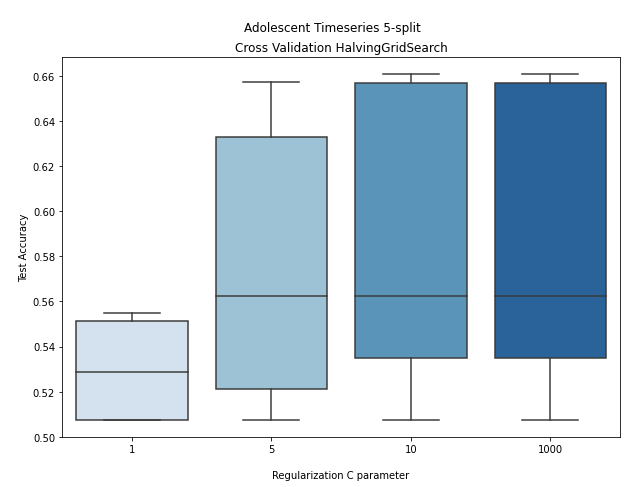

In [58]:
# Adolescent Boxplot C param
plt.figure(figsize= (10, 7))
sns.boxplot(x = df['param_C'], 
            y = df['mean_test_score'], 
            palette = 'Blues'
            )
plt.suptitle("\nAdolescent Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nRegularization C parameter")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/ADOL/AD_detrend_Cboxplot.png", dpi = 200)
plt.show()

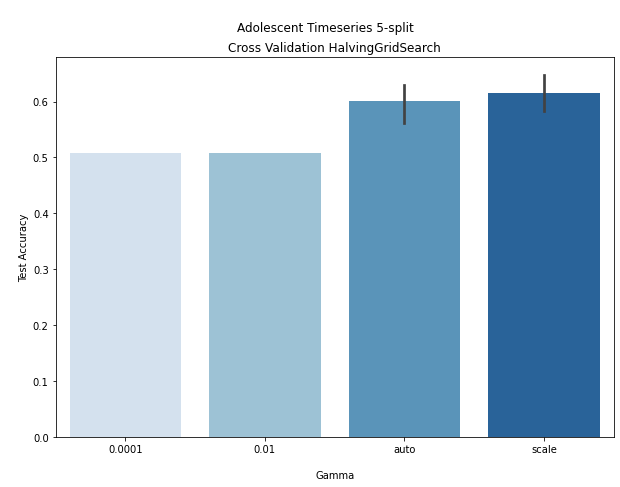

In [73]:
#Adolescent Gamma Parameter
plt.figure(figsize= (10, 7))
sns.barplot(x = df['param_gamma'], 
            y = df['mean_test_score'], 
            palette = "Blues", 
            )
plt.suptitle("\nAdolescent Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nGamma")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/ADOL/AD_detrend_gammaboxplot.png", dpi = 200)
plt.show()

In [ ]:
## Cross Validation accuracy scores recorded

dictionary = {"Cross Validation Adolescent Train run 2/Test run 3": ["1","2","3","4","5","Average"], 
              "Unnormalized": [.50, .51, .50, .50, .50, .50],
              "PSC per run": [.53, .63, .50, .50, .59, .55 ], 
              "PSC + Z Norm per Subject": [.63, .72, .62, .58, .52, .61], 
              "PSC + Z Norm per Run": [.68, .75, .73, .71, .77, .73], 
              "Z Norm per Run (No PSC)": [.62, .71, .72, .65, .63, .67]
              }

df = pd.DataFrame(dictionary)
df.set_index("Cross Validation Adolescent Train run 2/Test run 3", inplace = True)
df

,Unnormalized,PSC per run,PSC + Z Norm per Subject,PSC + Z Norm per Run,Z Norm per Run (No PSC)
Cross Validation Adolescent Train run 2/Test run 3,,,,,
1,0.50,0.53,0.63,0.68,0.62
2,0.51,0.63,0.72,0.75,0.71
3,0.50,0.50,0.62,0.73,0.72
4,0.50,0.50,0.58,0.71,0.65
5,0.50,0.59,0.52,0.77,0.63
Average,0.50,0.55,0.61,0.73,0.67


## Young Adult Time Series Cross Validation
### Organize Data Young Adult for Cross Validation
If we are performing cross validation, we need to get the data without custom splitting

In [ ]:
%%time
# Get mat file 
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels' 
from_mat = 'unnorm' #'psc' 'unnorm'
data_type = "YA_YA"
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key



#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename2 = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']



# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename2 in i.key:
    statement = True

if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename2}")
  f = open(f"{data_path}{filename2}", "wb")
  pickle.dump(data, f)
  f.close()
elif statement == True:
  print("Loading in masked data")
  data = access_load_data(filename2, False)


Loading in masked data
CPU times: user 27.9 s, sys: 33.9 s, total: 1min 1s
Wall time: 1min 1s


In [ ]:
%%time 
# Split dataset into young adults
ya = subject_ids[33:]
print("Number of subjects for Young Adult ", len(ya))

#Function Calls
norm = "Detrend_Znorm" #"RUNS" , "SUBJECT"
x_id = ya[:12]
xt_id = ya[12:15]

group_sub_ids = (x_id, xt_id)
runs_train = [1,2] # Grab run 2, 3 (0 indexing)
runs_test = [1,2] 

X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

Number of subjects for Young Adult  19
Normalizing Each based on Detrend_Znorm...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Final X data shape to feed into Time Series Cross Validation (2520, 237979)
Final y data shape to feed into Time Series Cross Validation (2520,)
CPU times: user 11 s, sys: 30.8 s, total: 41.8 s
Wall time: 10.1 s


### Run the Time Series Cross Validation

In [ ]:
max_train = 1000
test_size = None
splits = 5
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
data_type = "YA_YA"

directory = f'metrics/group_svm/{mask_type}/'
param_dict = {'C': [0.1, 1, 5, 10, 1000],
              'gamma': [0.001, 0.01, 'auto', 'scale'],
              'max_iter': [1000],
              }
gd_srch = True
file_name2 = f'{directory}{data_type}_{mask_type}_grdsrchcv.pkl'

time_series_cv(X, y, max_train, test_size, splits, gd_srch, param_dict, file_name2)

Uploading gridsearch results to cloud...
upload complete for metrics/group_svm/mask/YA_YA_mask_grdsrchcv.pkl
Best parameters:  {'C': 1000, 'gamma': 'auto', 'max_iter': 1000}
Best estimator:  SVC(C=1000, class_weight='balanced', gamma='auto', max_iter=1000,
    random_state=42)
Best score:  0.7214285714285713
CV results:  {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2]), 'n_resources': array([ 280,  280,  280,  280,  280,  280,  280,  280,  280,  280,  280,
        280,  280,  280,  280,  280,  280,  280,  280,  280,  840,  840,
        840,  840,  840,  840,  840, 2520, 2520, 2520]), 'mean_fit_time': array([ 0.60020423,  0.59157782,  0.58671317,  0.65828686,  0.59239783,
        0.58528438,  0.58527875,  0.67405195,  0.58247256,  0.57878013,
        0.58269887,  0.69325771,  0.58782315,  0.57697067,  0.59684057,
        0.6730135 ,  0.5946578 ,  0.57829533,  0.58266516,  0.68252306,
        4.50768681,  4.57410164,  4.555

## Check gridsearch scores

In [61]:
grid_dict = access_load_data('metrics/group_svm/mask/YA_YA_mask_grdsrchcv.pkl', False)

In [62]:
import pandas as pd
grid_df = pd.DataFrame(grid_dict['grid_search'][0])
g = grid_df[['param_C',	'mean_test_score']]
g.head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_max_iter,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,280,0.600204,0.222629,2.517570,0.625231,0.1,0.001,1000,"{'C': 0.1, 'gamma': 0.001, 'max_iter': 1000}",...,0.452174,0.046422,27,0.608696,0.526882,0.504505,0.504505,0.477477,0.524413,0.044956
1,0,280,0.591578,0.230502,2.490192,0.657954,0.1,0.01,1000,"{'C': 0.1, 'gamma': 0.01, 'max_iter': 1000}",...,0.452174,0.046422,27,0.608696,0.526882,0.504505,0.504505,0.477477,0.524413,0.044956
2,0,280,0.586713,0.228279,2.470611,0.649167,0.1,auto,1000,"{'C': 0.1, 'gamma': 'auto', 'max_iter': 1000}",...,0.452174,0.046422,27,0.608696,0.526882,0.504505,0.504505,0.477477,0.524413,0.044956
3,0,280,0.658287,0.237998,2.472598,0.635622,0.1,scale,1000,"{'C': 0.1, 'gamma': 'scale', 'max_iter': 1000}",...,0.452174,0.046422,27,0.608696,0.526882,0.504505,0.504505,0.477477,0.524413,0.044956
4,0,280,0.592398,0.234053,2.476787,0.647436,1,0.001,1000,"{'C': 1, 'gamma': 0.001, 'max_iter': 1000}",...,0.469565,0.059296,19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0,280,0.585284,0.229767,2.474220,0.652180,1,0.01,1000,"{'C': 1, 'gamma': 0.01, 'max_iter': 1000}",...,0.469565,0.059296,19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0,280,0.585279,0.228104,2.463329,0.638431,1,auto,1000,"{'C': 1, 'gamma': 'auto', 'max_iter': 1000}",...,0.617391,0.110507,17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,0,280,0.674052,0.243086,2.467836,0.644881,1,scale,1000,"{'C': 1, 'gamma': 'scale', 'max_iter': 1000}",...,0.613043,0.117793,18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0,280,0.582473,0.224247,2.454681,0.651089,5,0.001,1000,"{'C': 5, 'gamma': 0.001, 'max_iter': 1000}",...,0.469565,0.059296,19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,0,280,0.578780,0.222064,2.458893,0.656549,5,0.01,1000,"{'C': 5, 'gamma': 0.01, 'max_iter': 1000}",...,0.469565,0.059296,19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


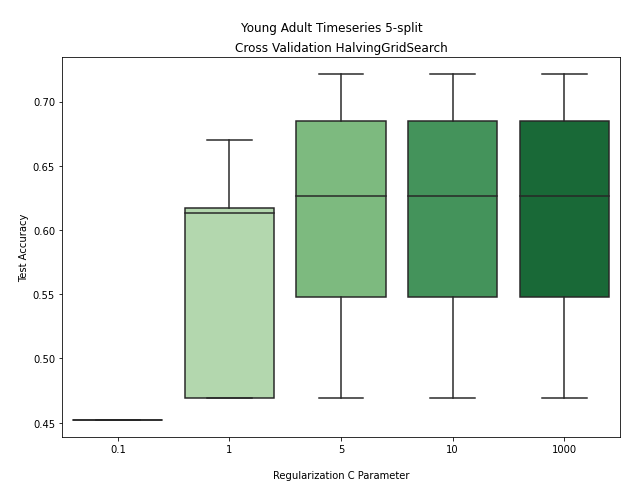

In [71]:
## Young Adult C Param Boxplot
plt.figure(figsize= (10, 7))
sns.boxplot(x = g['param_C'], 
            y = g['mean_test_score'],
            palette = 'Greens'
            )

plt.suptitle("\nYoung Adult Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nRegularization C Parameter")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/YA/YA_detrend_Cboxplot.png", dpi = 200)
plt.show()

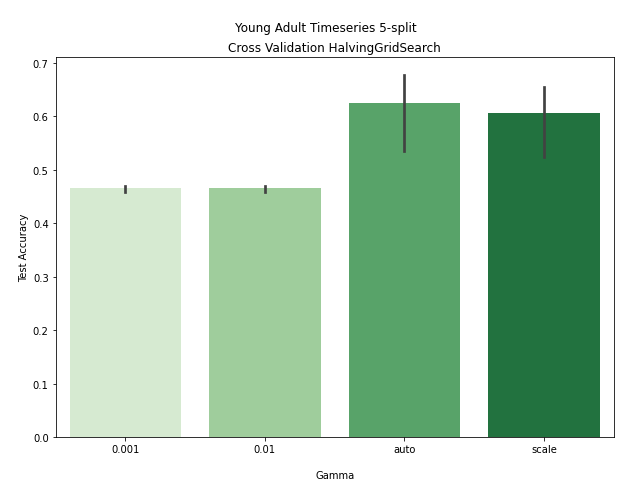

In [72]:
## Young Adult Gamma Barplot
plt.figure(figsize= (10, 7))
sns.barplot(x = grid3['param_gamma'], 
            y = grid3['mean_test_score'],
            palette = 'Greens'
            )

plt.suptitle("\nYoung Adult Timeseries 5-split")
plt.title('Cross Validation HalvingGridSearch')
plt.xlabel("\nGamma")
plt.ylabel("\nTest Accuracy")
plt.savefig("/content/gdrive/MyDrive/YA/YA_detrend_gammaboxplot.png", dpi = 200)
plt.show()

In [ ]:
## Cross Validation accuracy scores recorded

dictionary = {"Cross Validation Young Adult Train run 2/Test run 3": ["1","2","3","4","5","Average"], "Unnormalized": [.49, .54, .51, .49, .50, .51],
              "PSC per run": [.49, .61, .60, .62, .50, .56 ], "PSC + Z Norm per Run": [.77, .76, .82, .79, .80, .79],
              "Z Norm per Run (No PSC)": [.77, .75, .82, .81, .80, .79]}

df = pd.DataFrame(dictionary)
df.set_index("Cross Validation Young Adult Train run 2/Test run 3", inplace = True)
df

In [ ]:
# For YA znorm whole mask
"""
Predicting...
1it [03:17, 197.81s/it]Cross Validation Split 1 Accuracy score: 0.6898496240601504
Fitting Classifier for iteration number 2
Predicting...
2it [10:07, 322.61s/it]Cross Validation Split 2 Accuracy score: 0.8120300751879699
Fitting Classifier for iteration number 3
Predicting...
3it [20:03, 447.25s/it]Cross Validation Split 3 Accuracy score: 0.6917293233082706
Fitting Classifier for iteration number 4
Predicting...
4it [31:52, 550.50s/it]Cross Validation Split 4 Accuracy score: 0.7612781954887218
Fitting Classifier for iteration number 5
Predicting...
5it [46:36, 559.36s/it]Cross Validation Split 5 Accuracy score: 0.7800751879699248
Mean Accuracy: 0.7469924812030075"""